In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy 
import pickle
import warnings
import cProfile

from time import time

from astropy.stats import sigma_clip
from astropy.table import Table, Column, vstack
from scipy.ndimage.filters import gaussian_filter

import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from astroML.stats import binned_statistic_2d

from asap import io
from asap import smf 
from asap import shmr
from asap import config
from asap import fitting
from asap import ensemble
from asap import plotting
from asap.parameters import AsapParams
from asap.likelihood import ln_likelihood, ln_probability
from asap.predictions import (predict_mstar_basic, predict_smf, predict_mhalo,
                              predict_dsigma_profiles, make_model_predictions)

plt.rc('text', usetex=True)

## Evaluate the accuracy of the Mvir assignment using A.S.A.P model

In [3]:
test_dir = '../model'

# The configuration file
config_file = os.path.join(test_dir, 'asap_test_1.yaml')

# Initialize the model, load the data
cfg, params, obs_data, um_data = fitting.initial_model(config_file, verbose=True)


# The results of the final sampling process
result_file = os.path.join(test_dir, 'asap_test_1_sample.npz')

# Load in the final sampling results
(mod_result_samples, 
 mod_result_chains, 
 mod_result_lnprob, 
 mod_result_best, _, _) = io.load_npz_results(result_file)

# Predict the stellar mass in inner and outer apertures
logms_inn, logms_tot, sig_logms, mask_use = predict_mstar_basic(
    um_data['um_mock'], mod_result_best, min_logms=10.5,
    logmh_col=cfg['um']['logmh_col'], min_scatter=cfg['um']['min_scatter'],
    pivot=cfg['um']['pivot_logmh'])

# Predict the SMFs and DeltaSigma profiles
um_smf_tot, um_smf_inn, um_dsigma = make_model_predictions(
    mod_result_best, cfg, obs_data, um_data)

# Check the likelihood for SMF and DeltaSigma profiles
lnlike_smf, lnlike_dsigma = ln_likelihood(
    mod_result_best, cfg, obs_data, um_data, sep_return=True)

# The useful part of the mock catalog
um_mock_use = um_data['um_mock'][mask_use]

print("\n# Best parameters: ", mod_result_best)
print("# ln(Likelihood) for SMFs   : %8.4f" % lnlike_smf)
print("# ln(Likelihood) for DSigma : %8.4f" % lnlike_dsigma)

# Running model: asap_test_1
#    Will use emcee as sampler ...
#    Use   256 walkers with    snooker moves for   180 x  3 steps of burn-in
#    Use   256 walkers with        kde moves for   400 steps of sampling

# Observations:
# Galaxy catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# DSigma results: s16a_wide2_dsigma_logm11.6_12_bins.npy
# SMF of inner Mstar: s16a_wide2_massive_smf_m10_11.6.npy
# SMF of total Mstar: s16a_wide2_massive_smf_mmax_11.6.npy
# Covariances for SMFs: s16a_wide2_massive_smf_mmax_m10_cov.npy
# Reference SMF: primus_smf_z0.3_0.4.fits
# Column of inner Mstar: logm_10
# Column of total Mstar: logm_max

# UniverseMachine:
# Galaxy catalog : um_smdpl_insitu_exsitu_0.7124_basic_logmp_11.5_short.npy
# DSigma results : um_smdpl_insitu_exsitu_0.7124_basic_logmp_11.5_50m_r_0.08_50_22bins.npy
# Volumn of the simulation:    205348196.23 Mpc^3
# Halo mass : logmh_host
# Stellar mass : logms_tot
# There are 12 DSigma profiles in this sample
# SMF for total stella

### Evaluate a slightly different model for test

In [4]:
def assign_mvir_plane(logm_max, logm_10, a_plane=3.257, a_pivot=11.72, 
                      b_plane=-2.456, b_pivot=11.34, c_plane=13.6901):
    """Assign Mvir to galaxies with observed aperture masses."""
    return a_plane * (logm_max - a_pivot) + b_plane * (logm_10 - b_pivot) + c_plane

In [7]:
from sklearn.externals import joblib

mstar_forest = joblib.load('../model/um_asap_default_mvir_random_forest.pkl') 

/usr/local/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.19.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.19.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [8]:
mod_result_mean = np.mean(mod_result_samples, axis=0)

# Evaluate the model using slightly different model parameters
logms_inn_test, logms_tot_test, sig_logms_test, mask_use_test = predict_mstar_basic(
    um_data['um_mock'], mod_result_mean, min_logms=11.45,
    logmh_col=cfg['um']['logmh_col'], min_scatter=cfg['um']['min_scatter'],
    pivot=cfg['um']['pivot_logmh'])

# Aperture mass array for UM mock galaxies
# Using all galaxies, including the satellites
um_mass_test = np.stack((logms_inn_test, logms_tot_test), axis=-1)

# True Mvir for these test galaxies
logmh_vir_test = um_data['um_mock'][mask_use_test]['logmh_vir']

In [9]:
logmh_mean, x_edges, y_edges = binned_statistic_2d(
    logms_tot_test, logms_inn_test, logmh_vir_test, np.nanmean, 
    bins=(25, 22))

logmh_std, x_edges, y_edges = binned_statistic_2d(
    logms_tot_test, logms_inn_test, logmh_vir_test, np.nanstd, 
    bins=(25, 22))

gal_den, x_edges, y_edges = binned_statistic_2d(
    logms_tot_test, logms_inn_test, logmh_vir_test, 'count', 
    bins=(25, 22))

# Predict Mvir for test galaxies using the built random forest regressor
logmh_vir_test_for = mstar_forest.predict(um_mass_test)

# Predict Mvir for test galaxies using the best-fit scaling relation
logmh_vir_test_pln = assign_mvir_plane(logms_tot_test, logms_inn_test)

logmh_mean_for, x_edges, y_edges = binned_statistic_2d(
    logms_tot_test, logms_inn_test, logmh_vir_test_for, np.nanmean, 
    bins=(25, 22))

logmh_mean_pln, x_edges, y_edges = binned_statistic_2d(
    logms_tot_test, logms_inn_test, logmh_vir_test_pln, np.nanmean, 
    bins=(25, 22))

/usr/local/lib/python3.7/site-packages/astroML/stats/_binned_statistic.py:340: RuntimeWarning: Mean of empty slice
  null = statistic([])
/usr/local/lib/python3.7/site-packages/astroML/stats/_binned_statistic.py:356: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/usr/local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/site-packages/astroML/stats/_binned_statistic.py:340: RuntimeWarning: Mean of empty slice
  null = statistic([])
/usr/local/lib/python3.7/site-packages/astroML/stats/_binned_statistic.py:356: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[se

### Random Forest method

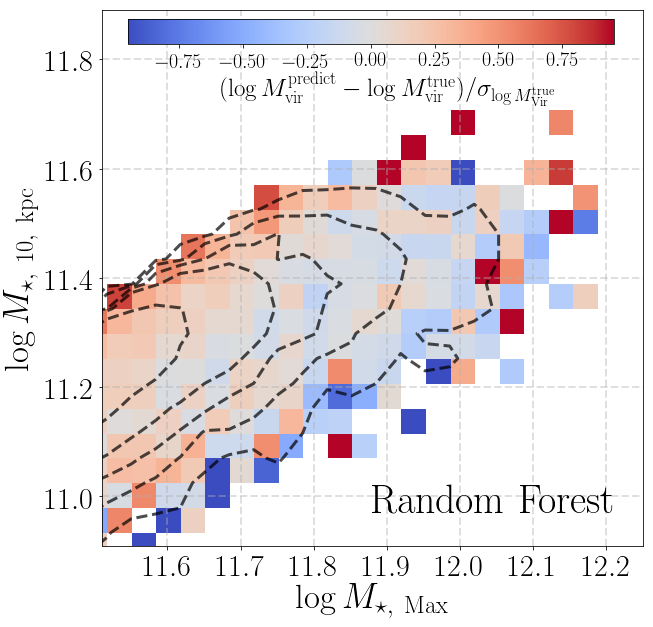

In [26]:
fig_1 = plt.figure(figsize=(9.0, 8.5))
fig_1.subplots_adjust(left=0.16, right=0.995, bottom=0.12, top=0.995, wspace=0.00, hspace=0.00)
ax1 = fig_1.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)

# M100-M10 scatter plot
HM = ax1.imshow((logmh_mean_for.T - logmh_mean.T) / logmh_std.T, 
                origin='lower',
                extent=[x_edges[0], x_edges[-1],
                        y_edges[0], y_edges[-1]],
                vmin=-0.95, vmax=0.95,
                aspect='auto', interpolation='nearest',
                cmap='coolwarm')

CT = ax1.contour(x_edges[:-1], y_edges[:-1],
                 gaussian_filter(gal_den.T, 0.15),
                 4, linewidths=3, linestyles='dashed',
                 colors='k', alpha=0.7,
                 levels=[5, 20, 50, 100, 300],
                 extend='neither')

# Colorbar
cax = fig_1.add_axes([0.20, 0.94, 0.75, 0.04])
cbar = plt.colorbar(HM, cax=cax, orientation='horizontal')
cbar.solids.set_edgecolor("face")
ax1.text(0.22, 0.82, 
         r'$(\log M_{\rm vir}^{\rm predict} - \log M_{\rm vir}^{\rm true}) / \sigma_{\log M_{\rm Vir}^{\rm true}}$', 
         transform=ax1.transAxes, size=25)

for tick in cax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in cax.yaxis.get_major_ticks():
    tick.label.set_fontsize(0)
    
ax1.text(0.50, 0.06, r'$\mathrm{Random\ Forest}$', transform=ax1.transAxes, size=40)

_ = ax1.set_xlim(11.51, 12.25)
_ = ax1.set_ylim(10.91, 11.89)

_ = ax1.set_xlabel(r'$\log M_{\star,\ \mathrm{Max}}$', fontsize=35)
_ = ax1.set_ylabel(r'$\log M_{\star,\ \mathrm{10,\ kpc}}$', fontsize=35)

### 2-D Scaling relation 

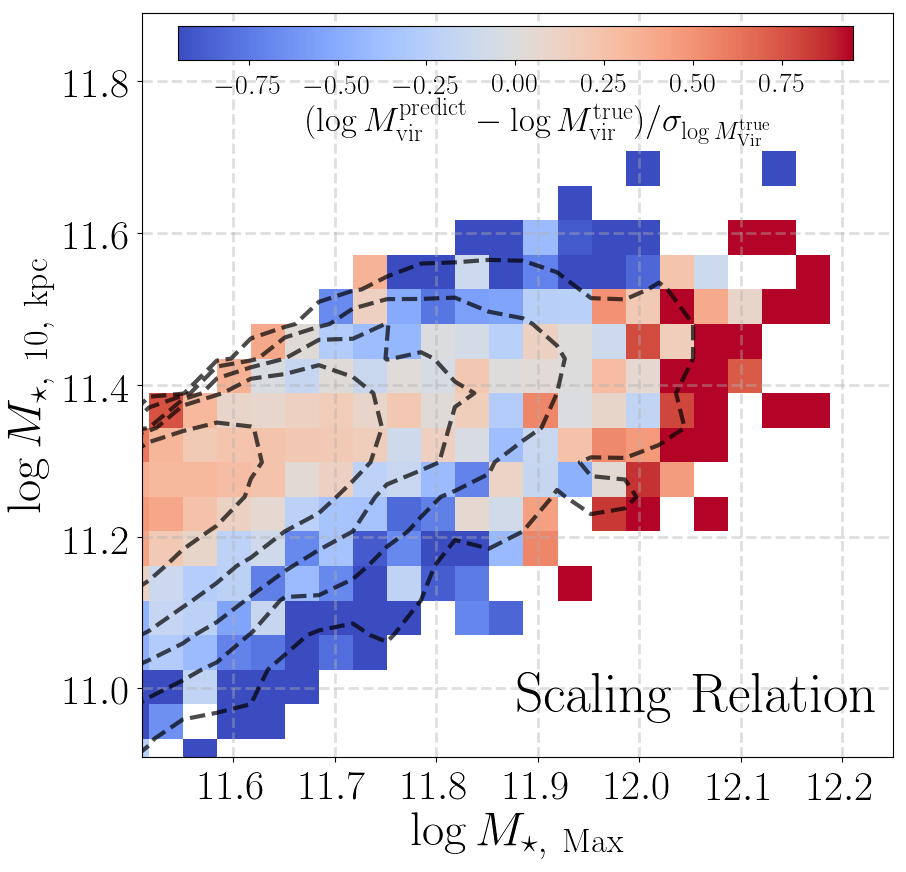

In [10]:
fig_2 = plt.figure(figsize=(9.0, 8.5))
fig_2.subplots_adjust(left=0.16, right=0.995, bottom=0.12, top=0.995, wspace=0.00, hspace=0.00)
ax1 = fig_2.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)

# M100-M10 scatter plot
HM = ax1.imshow((logmh_mean_pln.T - logmh_mean.T) / logmh_std.T, 
                origin='lower',
                extent=[x_edges[0], x_edges[-1],
                        y_edges[0], y_edges[-1]],
                vmin=-0.95, vmax=0.95,
                aspect='auto', interpolation='nearest',
                cmap='coolwarm')

CT = ax1.contour(x_edges[:-1], y_edges[:-1],
                 gaussian_filter(gal_den.T, 0.15),
                 4, linewidths=3, linestyles='dashed',
                 colors='k', alpha=0.7,
                 levels=[5, 20, 50, 100, 300],
                 extend='neither')

# Colorbar
cax = fig_2.add_axes([0.20, 0.94, 0.75, 0.04])
cbar = plt.colorbar(HM, cax=cax, orientation='horizontal')
cbar.solids.set_edgecolor("face")
ax1.text(0.22, 0.82, 
         r'$(\log M_{\rm vir}^{\rm predict} - \log M_{\rm vir}^{\rm true}) / \sigma_{\log M_{\rm Vir}^{\rm true}}$', 
         transform=ax1.transAxes, size=25)

for tick in cax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in cax.yaxis.get_major_ticks():
    tick.label.set_fontsize(0)
    
ax1.text(0.50, 0.06, r'$\mathrm{Scaling\ Relation}$', transform=ax1.transAxes, size=40)

_ = ax1.set_xlim(11.51, 12.25)
_ = ax1.set_ylim(10.91, 11.89)

_ = ax1.set_xlabel(r'$\log M_{\star,\ \mathrm{Max}}$', fontsize=35)
_ = ax1.set_ylabel(r'$\log M_{\star,\ \mathrm{10,\ kpc}}$', fontsize=35)

### Symbolic Regression

In [11]:
import _pickle as pickle

with open('../model/um_asap_default_mvir_symbolic_regression.pkl', 'rb') as f:
    est_gp = pickle.load(f)

In [42]:
# Predict Mvir for test galaxies using the symbolic regression model
logmh_vir_test_sym = est_gp.predict(um_mass_test)

logmh_mean_sym, x_edges, y_edges = binned_statistic_2d(
    logms_tot_test, logms_inn_test, logmh_vir_test_sym, np.nanmean, 
    bins=(25, 22))

/usr/local/lib/python3.7/site-packages/astroML/stats/_binned_statistic.py:340: RuntimeWarning: Mean of empty slice
  null = statistic([])
/usr/local/lib/python3.7/site-packages/astroML/stats/_binned_statistic.py:356: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


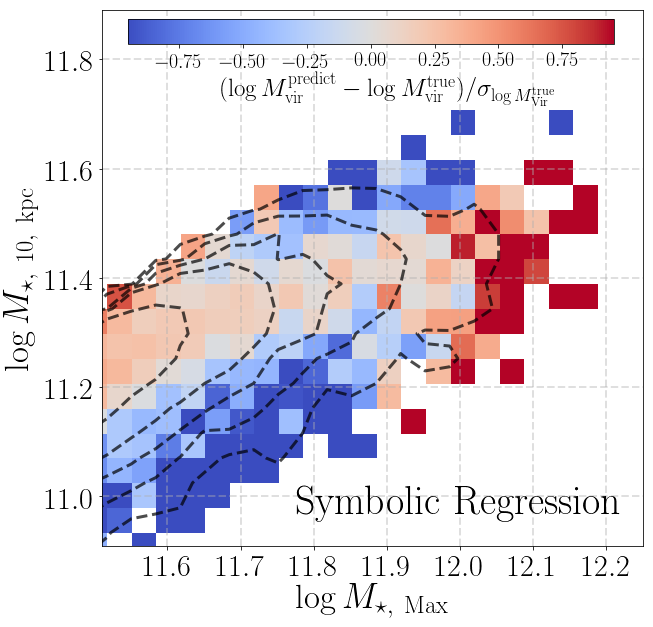

In [44]:
fig_3 = plt.figure(figsize=(9.0, 8.5))
fig_3.subplots_adjust(left=0.16, right=0.995, bottom=0.12, top=0.995, wspace=0.00, hspace=0.00)
ax1 = fig_3.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)

# M100-M10 scatter plot
HM = ax1.imshow((logmh_mean_sym.T - logmh_mean.T) / logmh_std.T, 
                origin='lower',
                extent=[x_edges[0], x_edges[-1],
                        y_edges[0], y_edges[-1]],
                vmin=-0.95, vmax=0.95,
                aspect='auto', interpolation='nearest',
                cmap='coolwarm')

CT = ax1.contour(x_edges[:-1], y_edges[:-1],
                 gaussian_filter(gal_den.T, 0.15),
                 4, linewidths=3, linestyles='dashed',
                 colors='k', alpha=0.7,
                 levels=[5, 20, 50, 100, 300],
                 extend='neither')

# Colorbar
cax = fig_3.add_axes([0.20, 0.94, 0.75, 0.04])
cbar = plt.colorbar(HM, cax=cax, orientation='horizontal')
cbar.solids.set_edgecolor("face")
ax1.text(0.22, 0.82, 
         r'$(\log M_{\rm vir}^{\rm predict} - \log M_{\rm vir}^{\rm true}) / \sigma_{\log M_{\rm Vir}^{\rm true}}$', 
         transform=ax1.transAxes, size=25)

for tick in cax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in cax.yaxis.get_major_ticks():
    tick.label.set_fontsize(0)
    
ax1.text(0.36, 0.06, r'$\mathrm{Symbolic\ Regression}$', transform=ax1.transAxes, size=40)

_ = ax1.set_xlim(11.51, 12.25)
_ = ax1.set_ylim(10.91, 11.89)

_ = ax1.set_xlabel(r'$\log M_{\star,\ \mathrm{Max}}$', fontsize=35)
_ = ax1.set_ylabel(r'$\log M_{\star,\ \mathrm{10,\ kpc}}$', fontsize=35)

### Save the figures

In [45]:
fig_1.savefig('fig/figB1_a.pdf', dpi=120)

fig_2.savefig('fig/figB1_b.pdf', dpi=120)